# Gaussian Processes

`jax` implementation of gaussian porcess and hyperparameter optimization.

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import jax.ops as ops
import matplotlib.pyplot as plt
import seaborn
import numpy as npy
import jax.nn as nn
plt.style.use('dark_background')
key = random.PRNGKey(0)

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Generate RAW data to sample

In [4]:
def f(x):
    y = 0.80 * x + npy.random.normal(0.0, 1.0)
    return y

In [5]:
# Vectorize function
f = npy.vectorize(f)

Though `vmap` from Jax might be better for vectorizing function, Noise would remain the same for all points. Hence, `numpy.vectorize` is used here.

In [2]:
# Generate Training Data
x_train = npy.random.choice(npy.linspace(0, 10, 100), 50)
y_train = f(x_train)
# Normalize the data
x_train = nn.normalize(x_train)
y_train = nn.normalize(y_train)

NameError: name 'f' is not defined

matrix inversion is being troublesome without normalizing data. 

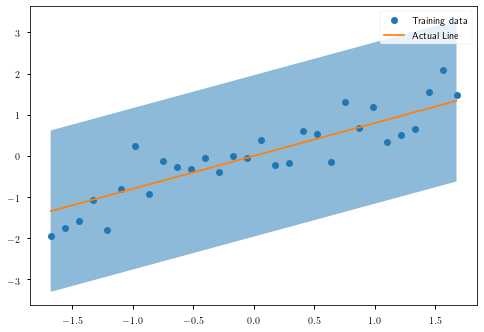

In [9]:
plt.plot(x_train, y_train, 'o', label="Training data")
plt.plot(x_train, 0.80*x_train, label="Actual Line")
plt.fill_between(x_train, 0.80*x_train + 1.0*1.96, 0.80*x_train -1.96*1.0, alpha=0.5)
plt.legend()

## Kernel

**Definition**: A kernel is a positive definite function of two inputs ($x_p$, $x_q$). These inputs are often vectors. 

$$ Cov[f(x_p), f(x_q)] = k(x_p, x_q) $$

Basically, kernels are a way for mapping the similarity between two data-points, and using these kernels we can customize how similarity between two data points is considered in a algorithm.

### Example:

Let us say we have sets of data-points, $X_{N \times D}$ and $Y_{P \times D}$. Where $D$ is the dimention of a data-point and $N,P$ is the number of data-points. Hence, when we are compute the covariance matrix between these data sets, it will have the dimention of  $N \times D$.

In [10]:
def squared_exponential(xp, xq):
    # Ensure these are one dimentional vectors
    x = xp - xq
    return np.exp(-0.5*np.dot(x, x.T))

In [11]:
def K(kernel_function, x, xs=None):
    if xs is None:
        return vmap(lambda x:vmap(lambda y: kernel_function(x, y))(x))(x)
    else:
        return vmap(lambda xp: vmap(lambda xq: squared_exponential(xp, xq))(xs))(x)

Check if the function is computing the kernel right.

In [12]:
def K_test(kernel, x, xs):
    k = np.zeros((x.shape[0], xs.shape[0])) # Number of elements in both both arrays
    for i in range(0, x.shape[0]):
        for j in range(0, xs.shape[0]):
            k = ops.index_update(k, ops.index[i,j], kernel(x[i], xs[j]))
    kn = K(kernel, x, xs)
    return k, kn

In [13]:
x = np.ones((2,5)) *0.5
xs = np.ones((3,5))
k, kjax = K_test(squared_exponential, x, x)

In [14]:
k

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

In [15]:
kjax

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

Nice !! looks like the kernel is right. 

 **Note** : Lets try a different kernel. We know that the data is linear. So a linear function might be better

In [16]:
def squared_distance(xp, xq):
    x = xp - xq
    return np.dot(x, x.T)

## GP Regression

Now that the kernel looks right. Lets head over to GPs.

In [17]:
x_test_new = np.linspace(0, 10, 10)
x_test_new = nn.normalize(x_test_new)

In [18]:
Kst = K(squared_distance, x_test_new, x_train)
Ktt = K(squared_distance, x_train, x_train) + np.eye(x_train.shape[0]) * 0.01
Kts = K(squared_distance, x_train, x_test_new)
Kss = K(squared_distance, x_test_new, x_test_new)
mu = np.dot(np.dot(Kst, np.linalg.inv(Ktt)), y_train)
Ktt_inv = np.linalg.inv(Ktt)
var = Kss - np.dot(np.dot(Kst, Ktt_inv), Kts)
std = np.sqrt(np.diag(var))

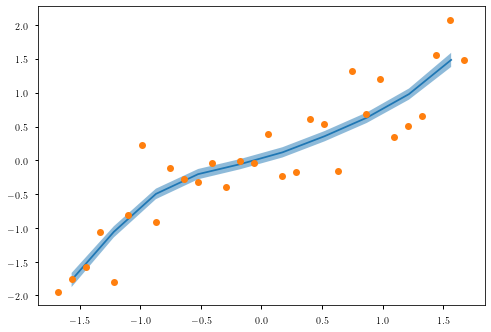

In [19]:
plt.plot(x_test_new, mu)
plt.fill_between(x_test_new, mu + 1.96*std, mu - 1.96*std, alpha=0.5)
plt.plot(x_train, y_train, 'o')

Noise is IID. Hence, white noise kernel might be sufficient.

## Hyperparamerter Tuning

In [48]:
def mlk(sigma, Ktt, y):
    Ktt = Ktt + sigma * np.eye(Ktt.shape[0])
    Ktt_inv = np.linalg.inv(Ktt)
    ml = -0.5 * np.dot(np.dot(y.T, Ktt_inv), y) - 0.5 * np.log(np.linalg.det(Ktt)) - 0.5 * np.log(2*3.14)
    return ml

In [69]:
Ktt = K(squared_distance, x_train, x_train)
der = grad(mlk, argnums=0)
hes = grad(grad(mlk, argnums=0))

In [74]:
sigma_t = 3.0
for i in range(0,100):
    sigma = sigma_t - 0.010*(der(sigma_t,Ktt,y_train)/hes(sigma_t,Ktt,y_train))
    print(sigma)
    if np.abs(sigma_t - sigma) < 0.00003:
        break
    sigma_t = sigma

2.9975734
2.9951475
2.9927225
2.9902983
2.987875
2.9854524
2.9830308
2.98061
2.97819
2.9757707
2.9733524
2.9709349
2.9685183
2.9661024
2.9636874
2.9612732
2.95886
2.9564474
2.9540358
2.9516249
2.949215
2.9468057
2.9443974
2.94199
2.9395833
2.9371774
2.9347725
2.9323683
2.929965
2.9275625
2.925161
2.92276
2.92036
2.917961
2.9155626
2.913165
2.9107685
2.9083726
2.9059777
2.9035835
2.9011903
2.8987978
2.896406
2.894015
2.891625
2.8892357
2.8868473
2.8844597
2.882073
2.879687
2.877302
2.8749177
2.8725343
2.8701518
2.86777
2.8653889
2.8630087
2.8606293
2.8582509
2.855873
2.8534963
2.8511202
2.848745
2.8463707
2.8439972
2.8416245
2.8392525
2.8368814
2.834511
2.8321416
2.829773
2.8274052
2.8250382
2.822672
2.8203065
2.817942
2.8155782
2.8132153
2.8108532
2.808492
2.8061314
2.8037717
2.8014128
2.7990549
2.7966976
2.7943413
2.7919858
2.789631
2.787277
2.7849238
2.7825716
2.78022
2.7778695
2.7755196
2.7731705
2.7708223
2.7684748
2.7661283
2.7637825
2.7614374


In [20]:
x_train = x_train
x_test_new = nn.normalize(np.linspace(0, 10, 100))
y_train = y_train
Kst = K(squared_distance, x_test_new, x_train)
Ktt = K(squared_distance, x_train, x_train) + np.eye(x_train.shape[0]) * sigma_t
Kts = K(squared_distance, x_train, x_test_new)
Kss = K(squared_distance, x_test_new, x_test_new)
mu = np.dot(np.dot(Kst, np.linalg.inv(Ktt)), y_train)
Ktt_inv = np.linalg.inv(Ktt)
var = Kss - np.dot(np.dot(Kst, Ktt_inv), Kts)
std = np.sqrt(np.diag(var))
plt.plot(x_test_new, mu)
plt.fill_between(x_test_new, mu + 1.96*std, mu - 1.96*std, alpha=0.5)
plt.plot(x_train, y_train, 'o')

NameError: name 'sigma_t' is not defined

## Summary: Notes on 
Tricky things when using GP:

        1. Ensuring that the matrix inverse is tractable.
        2. Optimizing the hyperparameters to fit to the data.
        3. Choosing the right kernel for the job.

In [42]:
import GPy

In [43]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [44]:
q = GPy.models.GPRegression(x_train.reshape(-1,1),y_train.reshape(-1,1),kernel)

In [45]:
q.optimize(messages=True)

In [46]:
q.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 28.914438247680664
Optimization restart 2/10, f = 28.91443634033203
Optimization restart 3/10, f = 28.914432525634766
Optimization restart 4/10, f = 28.9144344329834
Optimization restart 5/10, f = 28.9144344329834
Optimization restart 6/10, f = 28.9144344329834
Optimization restart 7/10, f = 28.914438247680664
Optimization restart 8/10, f = 28.91443634033203
Optimization restart 9/10, f = 28.9144344329834
Optimization restart 10/10, f = 28.914430618286133


In [47]:
a, b = q.predict(x_test_new.reshape(-1,1))
a = a.reshape(100,)
b = b.reshape(100,)

 /usr/local/lib/python3.7/site-packages/jax/lax/lax.py:4578: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


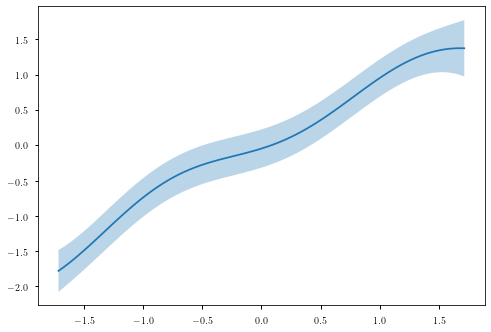

In [48]:
plt.plot(x_test_new, a)
plt.fill_between(x_test_new, a + 1.96*b, a - 1.96*b, alpha=0.3)

In [35]:
a.shape

(100, 1)

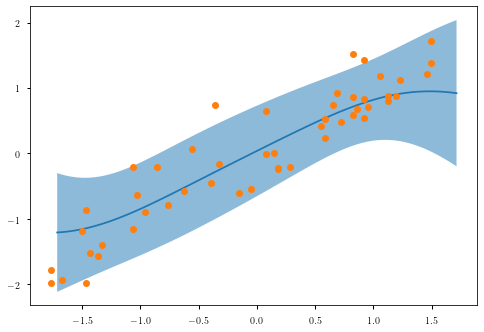

In [49]:
x_train = x_train
x_test_new = nn.normalize(np.linspace(0, 10, 100))
y_train = y_train
Kst = K(squared_distance, x_test_new, x_train)
Ktt = K(squared_distance, x_train, x_train) + np.eye(x_train.shape[0]) * 2.3
Kts = K(squared_distance, x_train, x_test_new)
Kss = K(squared_distance, x_test_new, x_test_new)
mu = np.dot(np.dot(Kst, np.linalg.inv(Ktt)), y_train)
Ktt_inv = np.linalg.inv(Ktt)
var = Kss - np.dot(np.dot(Kst, Ktt_inv), Kts)
std = np.sqrt(np.diag(var))
plt.plot(x_test_new, mu)
plt.fill_between(x_test_new, mu + 1.96*std, mu - 1.96*std, alpha=0.5)
plt.plot(x_train, y_train, 'o')

Though both the approaches are learning to predict the uncertanity. But the biggest hurdel in this process is optimizing for hyperparameters and extracting them.